In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

sumaiyabinteshahid_isic_challenge_dataset_2020_path = kagglehub.dataset_download('sumaiyabinteshahid/isic-challenge-dataset-2020')
anuragyadav7590_isic_2020_capstone_challenge_path = kagglehub.notebook_output_download('anuragyadav7590/isic-2020-capstone-challenge')

print('Data source import complete.')


In [ ]:
# Cell 1: Install PyTorch libraries
!pip install timm torchmetrics

# Cell 2: Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.models import EfficientNet_B0_Weights
from torch.amp import autocast, GradScaler

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import timm
from torchmetrics.classification import BinaryAUROC

# --- 0. Setup ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- 1. Define File Paths and Parameters ---
base_dir = '/kaggle/input/isic-challenge-dataset-2020/ISIC_2020_Dataset/'
csv_file = base_dir + 'ISIC_2020_Train_Metadata.csv'
train_dir = base_dir + 'train/'

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
N_EPOCHS = 10
LR = 1e-3

# --- 2. Create a Custom PyTorch Dataset ---
# (This section is unchanged)
class ISICDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_name'])
        label = torch.tensor(row['target'], dtype=torch.float32)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label.unsqueeze(-1)

# --- 3. Define Transforms (Augmentation) ---
# (This section is unchanged)
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

train_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=20),
    T.ToTensor(),
    T.Normalize(mean=preprocess.mean, std=preprocess.std)
])

val_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=preprocess.mean, std=preprocess.std)
])

# --- 4. Load Data and Create DataLoaders ---
# (This section is unchanged)
train_df_full = pd.read_csv(csv_file)
train_df_full['image_name'] = train_df_full['image_name'] + '.jpg'

train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.2,
    random_state=42,
    stratify=train_df_full['target']
)

train_dataset = ISICDataset(train_df, train_dir, transform=train_transform)
val_dataset = ISICDataset(val_df, train_dir, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")


# --- 5. Define the Model (EfficientNetB0) ---
# (This section is unchanged)
class SkinCancerModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=pretrained)
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.base_model(x)

model = SkinCancerModel().to(DEVICE)

# Freeze layers
for name, param in model.base_model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

# --- 6. Define Loss, Optimizer, and Metrics ---
# (This section is unchanged)
counts = train_df_full['target'].value_counts()
pos_weight = torch.tensor([counts[0] / counts[1]], dtype=torch.float32).to(DEVICE)
print(f"Positive weight for loss: {pos_weight.item():.2f} (to fight imbalance)")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.base_model.classifier.parameters(), lr=LR)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)
val_auc_metric = BinaryAUROC().to(DEVICE)

# --- 7. The Training Loop ---

# Initialize scaler with device_type as a positional argument
scaler = GradScaler('cuda')

best_val_auc = -1
patience_counter = 0
PATIENCE = 5

for epoch in range(N_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{N_EPOCHS} ---")

    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_loop = tqdm(train_loader, desc="Training")

    for images, labels in train_loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Use device_type as a positional argument
        with autocast('cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # --- (Scaler section is unchanged, but now uses the new scaler) ---
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # --------------------------------------------------

        train_loss += loss.item() * images.size(0)
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_dataset)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_auc_metric.reset()
    val_loop = tqdm(val_loader, desc="Validating")

    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Use device_type as a positional argument
            with autocast('cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_auc_metric.update(outputs.sigmoid(), labels.int())

    # <-- THIS IS THE ONLY LINE THAT CHANGED (FIXED THE TYPO)
    epoch_val_auc = val_auc_metric.compute().item()

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {epoch_val_auc:.4f}")

    # --- Handle Callbacks (Scheduler and EarlyStopping) ---
    scheduler.step(epoch_val_auc)

    if epoch_val_auc > best_val_auc:
        best_val_auc = epoch_val_auc
        patience_counter = 0
        save_path = '/kaggle/working/best_pytorch_model.pth'
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved to {save_path} with Val AUC: {best_val_auc:.4f}")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("--- Early stopping triggered ---")
        break

print("\n--- Training Complete ---")
print(f"Best Validation AUC achieved: {best_val_auc:.4f}")

Using device: cuda
Loaded 26500 training images and 6626 validation images.
Positive weight for loss: 55.72 (to fight imbalance)

--- Epoch 1/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.1935 | Val Loss: 1.0629 | Val AUC: 0.8205
New best model saved to /kaggle/working/best_pytorch_model.pth with Val AUC: 0.8205

--- Epoch 2/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.0244 | Val Loss: 1.0629 | Val AUC: 0.8235
New best model saved to /kaggle/working/best_pytorch_model.pth with Val AUC: 0.8235

--- Epoch 3/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.9769 | Val Loss: 1.0629 | Val AUC: 0.8296
New best model saved to /kaggle/working/best_pytorch_model.pth with Val AUC: 0.8296

--- Epoch 4/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.9375 | Val Loss: 1.0629 | Val AUC: 0.8505
New best model saved to /kaggle/working/best_pytorch_model.pth with Val AUC: 0.8505

--- Epoch 5/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.9261 | Val Loss: 1.0629 | Val AUC: 0.8520
New best model saved to /kaggle/working/best_pytorch_model.pth with Val AUC: 0.8520

--- Epoch 6/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.9253 | Val Loss: 1.0629 | Val AUC: 0.8407
Patience counter: 1/5

--- Epoch 7/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.8915 | Val Loss: 1.0629 | Val AUC: 0.8467
Patience counter: 2/5

--- Epoch 8/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.9046 | Val Loss: 1.0629 | Val AUC: 0.8523
New best model saved to /kaggle/working/best_pytorch_model.pth with Val AUC: 0.8523

--- Epoch 9/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.8903 | Val Loss: 1.0629 | Val AUC: 0.8461
Patience counter: 1/5

--- Epoch 10/10 ---


Training:   0%|          | 0/415 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f50f8aef2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10 | Train Loss: 0.8662 | Val Loss: 1.0629 | Val AUC: 0.8494
Patience counter: 2/5

--- Training Complete ---
Best Validation AUC achieved: 0.8523


In [ ]:
# Cell 1: Install and import everything
!pip install timm torchmetrics
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models import EfficientNet_B0_Weights
from torch.amp import autocast, GradScaler
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm.auto import tqdm
import timm

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split # Ye bhi import karo

# --- 0. Setup ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- 1. Define Paths and Parameters ---
# !!! IMPORTANT: Apna model path yahan update karo !!!
# (Apne notebook ka naam check kar lena)
MODEL_PATH = '/kaggle/input/notebook5461550b5d/best_pytorch_model.pth'
base_dir = '/kaggle/input/isic-challenge-dataset-2020/ISIC_2020_Dataset/'
csv_file = base_dir + 'ISIC_2020_Train_Metadata.csv'
train_dir = base_dir + 'train/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# --- 2. Define the Dataset Class (MUST be identical) ---
class ISICDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # CSV mein .jpg pehle se add kar diya tha training mein, isliye yahan bhi
        img_path = os.path.join(self.img_dir, row['image_name'])
        label = torch.tensor(row['target'], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label.unsqueeze(-1)

# --- 3. Define the Model Class (MUST be identical) ---
class SkinCancerModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=pretrained)
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.base_model(x)

# --- 4. Define val_transform (MUST be identical) ---
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
val_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=preprocess.mean, std=preprocess.std)
])

# --- 5. Load ONLY the Validation Data ---
train_df_full = pd.read_csv(csv_file)
# Important: Humne training mein hi .jpg add kar diya tha
train_df_full['image_name'] = train_df_full['image_name'] + '.jpg'

train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.2,
    random_state=42, # 42 use karna zaroori hai
    stratify=train_df_full['target']
)

val_dataset = ISICDataset(val_df, train_dir, transform=val_transform)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)
print(f"Loaded {len(val_dataset)} validation images for testing.")

# --- 6. Load the Model ---
model = SkinCancerModel().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval() # Eval mode
print("Model loaded successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda
Loaded 6626 validation images for testing.
Model loaded successfully!


Running model on validation set to get predictions for graphs...


  0%|          | 0/104 [00:00<?, ?it/s]


  Classification Report (Validation Set)
               precision    recall  f1-score   support

   Benign (0)       1.00      0.62      0.76      6509
Malignant (1)       0.04      0.91      0.08       117

     accuracy                           0.62      6626
    macro avg       0.52      0.77      0.42      6626
 weighted avg       0.98      0.62      0.75      6626


  Confusion Matrix (Validation Set)


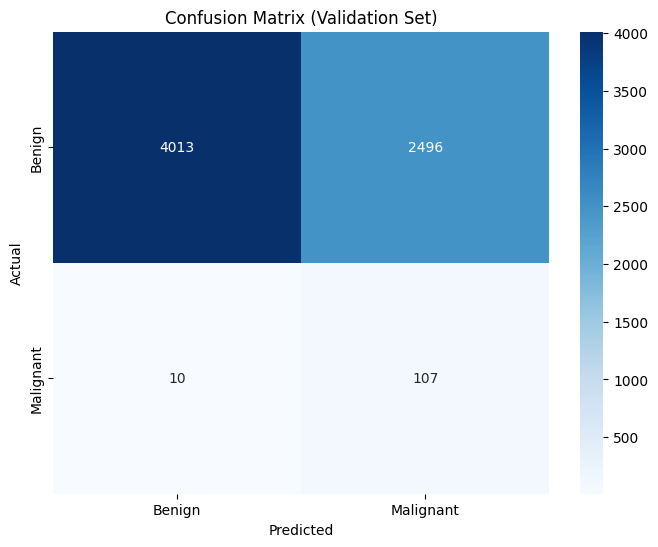


  ROC Curve (Validation Set)


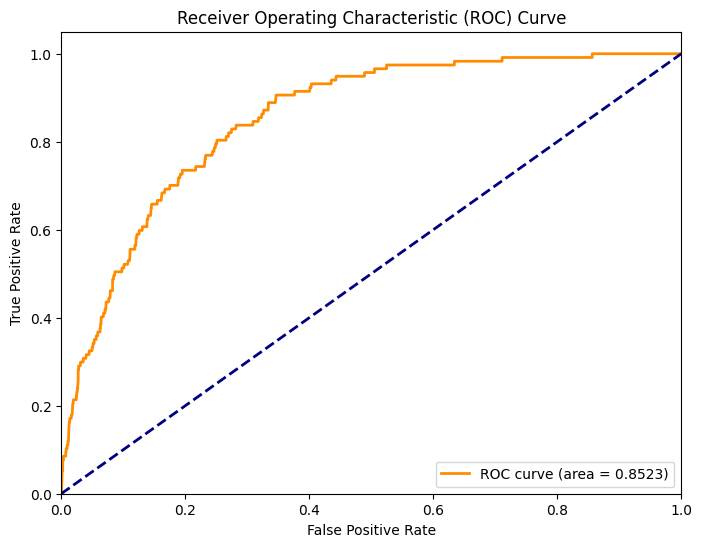

In [ ]:
# Cell 2: Graph plotting code (Ye pehle jaisa hi hai)

all_labels = []
all_probs = []

print("Running model on validation set to get predictions for graphs...")
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Yahan bhi autocast use karlo speed ke liye
        with autocast('cuda', dtype=torch.float16):
             outputs = model(images)

        probs = outputs.sigmoid()

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Lists to numpy arrays
y_true = np.array(all_labels)
y_pred_proba = np.array(all_probs)
y_pred_class = (y_pred_proba > 0.5).astype(int)

# --- Reports and Graphs ---
print("\n" + "="*30)
print("  Classification Report (Validation Set)")
print("="*30)
print(classification_report(y_true, y_pred_class, target_names=['Benign (0)', 'Malignant (1)']))

print("\n" + "="*30)
print("  Confusion Matrix (Validation Set)")
print("="*30)
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print("\n" + "="*30)
print("  ROC Curve (Validation Set)")
print("="*30)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


  Advanced Metrics
F2-Score (jo Recall ko 2x weight deta hai): 0.1742
Ye F1-Score se behtar metric hai medical tasks ke liye.

  Precision-Recall (PR) Curve


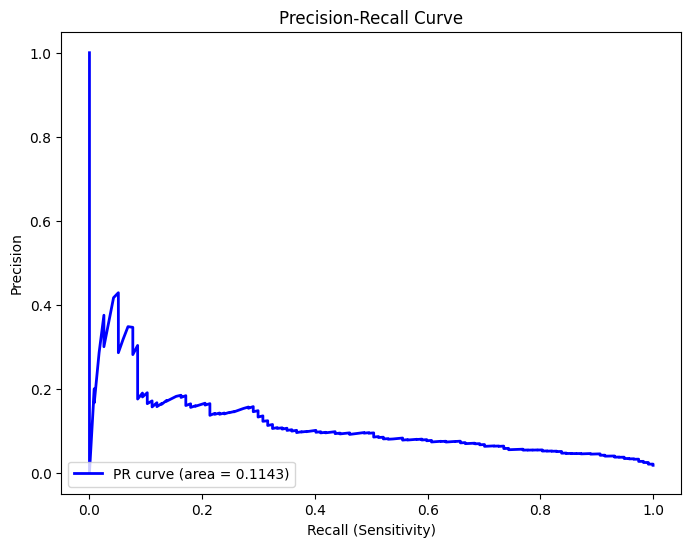


  Precision & Recall vs. Threshold


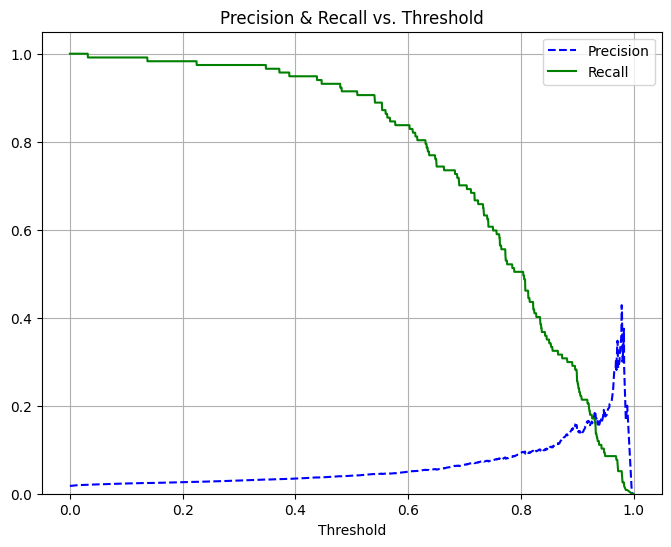

In [ ]:
# Naye metrics ke liye imports
from sklearn.metrics import precision_recall_curve, average_precision_score, fbeta_score

print("\n" + "="*30)
print("  Advanced Metrics")
print("="*30)

# --- 1. F2-Score Calculate Karein ---
# F2-Score recall ko 2 guna zyada importance deta hai
f2 = fbeta_score(y_true, y_pred_class, beta=2.0)
print(f"F2-Score (jo Recall ko 2x weight deta hai): {f2:.4f}")
print("Ye F1-Score se behtar metric hai medical tasks ke liye.")


# --- 2. Precision-Recall (PR) Curve ---
print("\n" + "="*30)
print("  Precision-Recall (PR) Curve")
print("="*30)

precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {avg_precision:.4f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# --- 3. Precision & Recall vs. Threshold ---
print("\n" + "="*30)
print("  Precision & Recall vs. Threshold")
print("="*30)

# Hum thresholds_pr se aakhiri element hata denge taaki length match ho
plt.figure(figsize=(8,6))
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title('Precision & Recall vs. Threshold')
plt.ylim([0, 1.05])
plt.grid(True)
plt.show()

Using device: cuda
Model loaded successfully.
Loaded 10982 test images metadata.

--- Predicting 5 Random Test Images ---


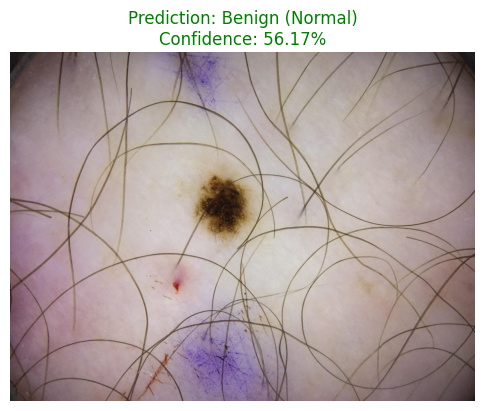

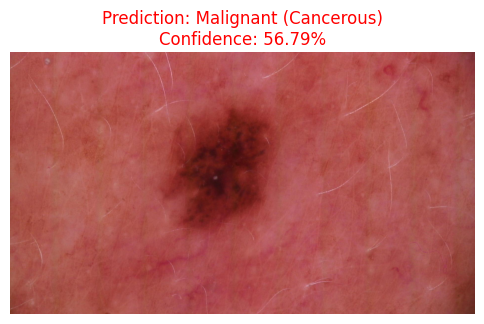

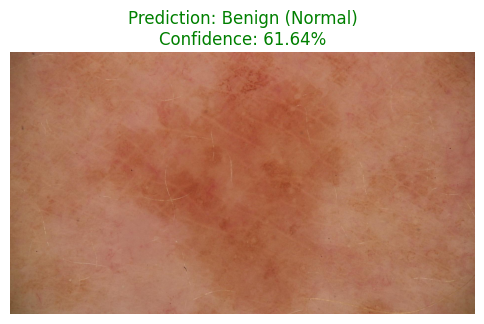

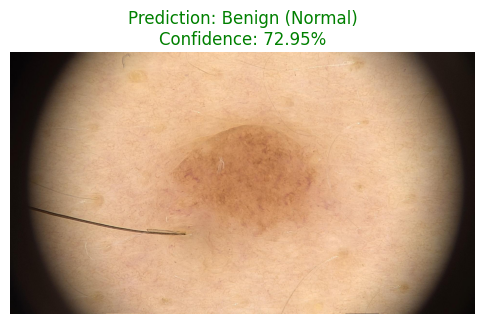

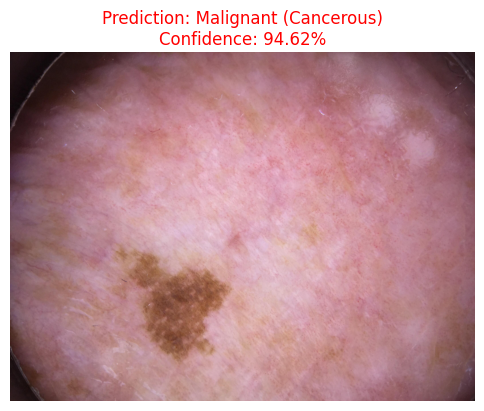

In [ ]:
# Cell 1: Pehle, saari zaroori cheezein import kar lein
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models import EfficientNet_B0_Weights
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm.auto import tqdm
import timm
import matplotlib.pyplot as plt
import random

# --- 0. Setup ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- 1. Define Paths and Parameters ---
# !!! IMPORTANT: Apna model path yahan update karo !!!
# (Ye aapke pichhle notebook ke output se aayega)
MODEL_PATH = '/kaggle/input/notebook5461550b5d/best_pytorch_model.pth'

# Dataset paths
base_dir = '/kaggle/input/isic-challenge-dataset-2020/ISIC_2020_Dataset'
test_csv_file = '/kaggle/input/isic-challenge-dataset-2020/ISIC_2020_Dataset/ISIC_2020_Test_Metadata.csv'
test_dir = '/kaggle/input/isic-challenge-dataset-2020/ISIC_2020_Dataset/test'

IMG_SIZE = (224, 224)

# --- 2. Define the Model Class (MUST be identical) ---
class SkinCancerModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=pretrained)
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.base_model(x)

# --- 3. Define test_transform (identical to val_transform) ---
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
test_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=preprocess.mean, std=preprocess.std)
])

# --- 4. Load the Model ---
model = SkinCancerModel().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval() # Set to evaluation mode!
print("Model loaded successfully.")

# --- 5. Load the Test CSV ---
test_df = pd.read_csv(test_csv_file)
print(f"Loaded {len(test_df)} test images metadata.")

# --- 6. 5 Random Images Select Karein aur Predict Karein ---
print("\n--- Predicting 5 Random Test Images ---")

# 'n=5' ko badal kar aap 10 images bhi kar sakte hain
random_samples = test_df.sample(n=5)

for index, row in random_samples.iterrows():
    image_name = row['image']
    image_path = os.path.join(test_dir, image_name + '.jpg')

    # Image load karein
    img = Image.open(image_path).convert("RGB")

    # Image ko transform karein
    img_tensor = test_transform(img).unsqueeze(0).to(DEVICE)

    # Prediction karein
    with torch.no_grad():
        output = model(img_tensor)
        probability = output.sigmoid().item()

    # Result determine karein
    if probability < 0.5:
        prediction = "Benign (Normal)"
        confidence = 100 * (1 - probability)
    else:
        prediction = "Malignant (Cancerous)"
        confidence = 100 * probability

    # Image aur Prediction dikhayein
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {prediction}\nConfidence: {confidence:.2f}%",
              color = "green" if prediction == "Benign (Normal)" else "red")
    plt.axis('off')
    plt.show()